# Feb 28, Mar 31, June 15, Aug 20, 2024: correlation matrices (functional networks)
modified: [../feb24/01c-desc-func_nws.ipynb](../feb24/01c-desc-func_nws.ipynb)

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
from scipy import sparse, stats
import glob

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [3]:
def create_dataframe(files):
    def get_ts(file):
        ts = np.loadtxt(file)
        ts = stats.zscore(ts, axis=0, nan_policy='omit')
        return ts        

    dataset_df = []

    for file in tqdm(files):
        ssr = file.split('/')[-1].split('_')
        sub, ses, run = [ssr[i].split('-')[-1] for i in range(3)]
        ts = get_ts(file)
        # fc = get_fc(ts)
        df = pd.DataFrame({
            'sub':[int(sub[-2:])],
            'ses':[int(ses)],
            'run':[int(run)],
            'ssr':[ssr[:-1]],
            'ts':[ts],
        })
        dataset_df.append(df)
        # save_fc(fc, ssr)
        
    dataset_df = pd.concat(dataset_df)
    dataset_df = dataset_df.sort_values(
        by=['sub', 'ses', 'run'],
    ).reset_index(drop=True)
    return dataset_df

In [4]:
def get_cols(args):
    all_cols = ['sub', 'ses', 'run']
    idx = [i for i, c in enumerate(all_cols) if args.DATA_UNIT in c]
    idx = idx[0] if len(idx) > 0 else idx
    cols = [c for i, c in enumerate(all_cols) if i <= idx] if type(idx) == int else []
    return cols

In [5]:
def make_ssr(cols, key):
    d = []
    for c, k in zip(cols, key):
        if 'sub' in c:
            d.append(f'{c}-SLC{k:02d}')
        else:
            d.append(f'{c}-{k}')
    return d

def get_fc(args, ts):
    if args.GRAPH_METHOD == f'pearson-corr':
        fc = np.corrcoef(ts, rowvar=False)
    elif args.GRAPH_METHOD == f'partial-corr':
        pass # TODO
    elif args.GRAPH_METHOD == f'mutual-info':
        pass # TODO
    
    fc = fc[np.tril_indices(fc.shape[0], k=-1)]
    fc[np.isnan(fc)] = 0.0

    if args.THRESHOLDING == f'positive':
        v = fc
    elif args.THRESHOLDING == f'absolute':
        v = np.abs(fc)
    
    q = np.percentile(v, q=100-args.EDGE_DENSITY)
    
    if args.EDGE_DEF == f'binary':
        fc_ = v > q
    elif args.EDGE_DEF == f'weighted':
        fc_ = (v > q) * fc

    FC = np.zeros((args.num_rois, args.num_rois))
    FC[np.tril_indices(FC.shape[0], k=-1)] = fc_
    FC = (FC + FC.T)
    return FC

def make_graph(fc):
        fc = np.tril(fc)
        edges = np.where(fc)
        edge_list = list(zip(*[*edges, fc[edges]]))
        g = gt.Graph(
            edge_list, 
            eprops=[('weight', 'double')],
            directed=False,
        )
        return g

def save_graph(g, ssr):
    file = '_'.join(ssr + ['desc-graph.gt.gz'])
    file = f'{GRAPH_path}/{file}'
    g.save(file)
    return file

def create_graphs_df(args, dataset_df, cols):
    if len(cols) > 0:
        graphs_df = []
        for key, group in tqdm(dataset_df.groupby(by=cols)):
            key = key if type(key) == tuple else (key,)
            ssr = make_ssr(cols, key)
            ts = np.concatenate(group['ts'].to_list(), axis=0)
            fc = get_fc(args, ts)
            g = make_graph(fc)
            file = save_graph(g, ssr)
            
            df = pd.DataFrame({})
            for s in ssr:
                c, k = s.split('-')
                df[c] = [k]
            df['graph'] = [g]
            df['file'] = [file]
            
            graphs_df.append(df)

        graphs_df = pd.concat(graphs_df).reset_index(drop=True)
    else: # unit-grp
        ts = np.concatenate(dataset_df['ts'].to_list(), axis=0)
        fc = get_fc(args, ts)
        g = make_graph(fc)
        file = save_graph(g, [f'grp'])
        graphs_df = pd.DataFrame({
            'graph': [g],
            'file': [file],
        })
    return graphs_df

In [6]:
def display_graph(args, g):
    edges = [list(edge) for edge in list(g.get_edges())]
    v1, v2 = list(zip(*edges))
    weights = list(g.ep['weight'])
    G = np.zeros((args.num_rois, args.num_rois))
    G[v1, v2] = weights
    G = (G + G.T)

    fig, axs = plt.subplots(1, 1, figsize=(5, 4), dpi=80)
    ax = axs
    sns.heatmap(G, ax=ax, square=True, cmap=cmr.iceburn, center=0)
    return fig

In [7]:
args.type = 'allen'
args.roi_size = 'x'
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 172

PARC_DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

In [8]:
GRAPH_DEFS = [f'constructed']
GRAPH_METHODS = [f'pearson-corr'] #, f'partial-corr', f'mutual-info']
THRESHOLDINGS = [f'positive', f'absolute']
EDGE_DEFS = [f'binary', f'weighted']
EDGE_DENSITIES = [10, 15, 20, 25]
LAYER_DEFS = [f'individual'] #, f'multilayer']
DATA_UNITS = [f'ses', f'sub']

In [9]:
ITERS = product(
    GRAPH_METHODS, THRESHOLDINGS, 
    EDGE_DEFS, EDGE_DENSITIES, DATA_UNITS
)

constructed pearson-corr positive binary 10 individual ses


100%|██████████| 30/30 [00:00<00:00, 129.21it/s]


,sub,ses,graph,file
0,SLC01,1,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC01,2,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC01,3,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC02,1,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC02,2,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr positive binary 10 individual sub


100%|██████████| 10/10 [00:00<00:00, 78.41it/s]


,sub,graph,file
0,SLC01,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC02,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC03,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC04,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC05,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr positive binary 15 individual ses


100%|██████████| 30/30 [00:00<00:00, 127.11it/s]


,sub,ses,graph,file
0,SLC01,1,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC01,2,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC01,3,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC02,1,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC02,2,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr positive binary 15 individual sub


100%|██████████| 10/10 [00:00<00:00, 74.62it/s]


,sub,graph,file
0,SLC01,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC02,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC03,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC04,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC05,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr positive binary 20 individual ses


100%|██████████| 30/30 [00:00<00:00, 108.88it/s]


,sub,ses,graph,file
0,SLC01,1,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC01,2,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC01,3,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC02,1,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC02,2,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr positive binary 20 individual sub


100%|██████████| 10/10 [00:00<00:00, 71.12it/s]


,sub,graph,file
0,SLC01,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC02,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC03,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC04,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC05,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr positive binary 25 individual ses


100%|██████████| 30/30 [00:00<00:00, 96.87it/s]


,sub,ses,graph,file
0,SLC01,1,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC01,2,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC01,3,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC02,1,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC02,2,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr positive binary 25 individual sub


100%|██████████| 10/10 [00:00<00:00, 65.59it/s]


,sub,graph,file
0,SLC01,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC02,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC03,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC04,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC05,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr positive weighted 10 individual ses


100%|██████████| 30/30 [00:00<00:00, 126.45it/s]


,sub,ses,graph,file
0,SLC01,1,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC01,2,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC01,3,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC02,1,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC02,2,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr positive weighted 10 individual sub


100%|██████████| 10/10 [00:00<00:00, 85.32it/s]


,sub,graph,file
0,SLC01,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC02,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC03,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC04,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC05,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr positive weighted 15 individual ses


100%|██████████| 30/30 [00:00<00:00, 119.40it/s]


,sub,ses,graph,file
0,SLC01,1,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC01,2,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC01,3,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC02,1,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC02,2,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr positive weighted 15 individual sub


100%|██████████| 10/10 [00:00<00:00, 75.72it/s]


,sub,graph,file
0,SLC01,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC02,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC03,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC04,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC05,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr positive weighted 20 individual ses


100%|██████████| 30/30 [00:00<00:00, 97.45it/s]


,sub,ses,graph,file
0,SLC01,1,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC01,2,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC01,3,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC02,1,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC02,2,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr positive weighted 20 individual sub


100%|██████████| 10/10 [00:00<00:00, 67.99it/s]


,sub,graph,file
0,SLC01,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC02,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC03,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC04,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC05,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr positive weighted 25 individual ses


100%|██████████| 30/30 [00:00<00:00, 86.34it/s]


,sub,ses,graph,file
0,SLC01,1,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC01,2,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC01,3,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC02,1,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC02,2,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr positive weighted 25 individual sub


100%|██████████| 10/10 [00:00<00:00, 63.07it/s]


,sub,graph,file
0,SLC01,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC02,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC03,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC04,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC05,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr absolute binary 10 individual ses


100%|██████████| 30/30 [00:00<00:00, 125.01it/s]


,sub,ses,graph,file
0,SLC01,1,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC01,2,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC01,3,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC02,1,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC02,2,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr absolute binary 10 individual sub


100%|██████████| 10/10 [00:00<00:00, 80.68it/s]


,sub,graph,file
0,SLC01,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC02,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC03,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC04,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC05,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr absolute binary 15 individual ses


100%|██████████| 30/30 [00:00<00:00, 110.65it/s]


,sub,ses,graph,file
0,SLC01,1,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC01,2,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC01,3,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC02,1,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC02,2,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr absolute binary 15 individual sub


100%|██████████| 10/10 [00:00<00:00, 77.38it/s]


,sub,graph,file
0,SLC01,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC02,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC03,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC04,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC05,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr absolute binary 20 individual ses


100%|██████████| 30/30 [00:00<00:00, 107.53it/s]


,sub,ses,graph,file
0,SLC01,1,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC01,2,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC01,3,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC02,1,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC02,2,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr absolute binary 20 individual sub


100%|██████████| 10/10 [00:00<00:00, 70.37it/s]


,sub,graph,file
0,SLC01,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC02,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC03,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC04,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC05,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr absolute binary 25 individual ses


100%|██████████| 30/30 [00:00<00:00, 83.83it/s]


,sub,ses,graph,file
0,SLC01,1,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC01,2,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC01,3,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC02,1,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC02,2,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr absolute binary 25 individual sub


100%|██████████| 10/10 [00:00<00:00, 54.86it/s]


,sub,graph,file
0,SLC01,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC02,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC03,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC04,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC05,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr absolute weighted 10 individual ses


100%|██████████| 30/30 [00:00<00:00, 129.87it/s]


,sub,ses,graph,file
0,SLC01,1,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC01,2,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC01,3,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC02,1,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC02,2,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr absolute weighted 10 individual sub


100%|██████████| 10/10 [00:00<00:00, 81.69it/s]


,sub,graph,file
0,SLC01,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC02,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC03,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC04,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC05,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr absolute weighted 15 individual ses


100%|██████████| 30/30 [00:00<00:00, 116.30it/s]


,sub,ses,graph,file
0,SLC01,1,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC01,2,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC01,3,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC02,1,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC02,2,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr absolute weighted 15 individual sub


100%|██████████| 10/10 [00:00<00:00, 73.57it/s]


,sub,graph,file
0,SLC01,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC02,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC03,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC04,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC05,"<Graph object, undirected, with 171 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr absolute weighted 20 individual ses


100%|██████████| 30/30 [00:00<00:00, 101.89it/s]


,sub,ses,graph,file
0,SLC01,1,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC01,2,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC01,3,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC02,1,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC02,2,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr absolute weighted 20 individual sub


100%|██████████| 10/10 [00:00<00:00, 67.75it/s]


,sub,graph,file
0,SLC01,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC02,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC03,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC04,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC05,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr absolute weighted 25 individual ses


100%|██████████| 30/30 [00:00<00:00, 90.47it/s]


,sub,ses,graph,file
0,SLC01,1,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC01,2,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC01,3,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC02,1,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC02,2,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


constructed pearson-corr absolute weighted 25 individual sub


100%|██████████| 10/10 [00:00<00:00, 58.09it/s]


,sub,graph,file
0,SLC01,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
1,SLC02,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
2,SLC03,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
3,SLC04,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...
4,SLC05,"<Graph object, undirected, with 172 vertices a...",/home/govindas/mouse_dataset/roi_results_v2/ty...


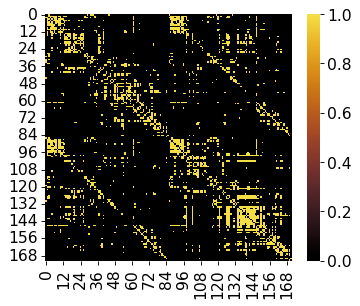

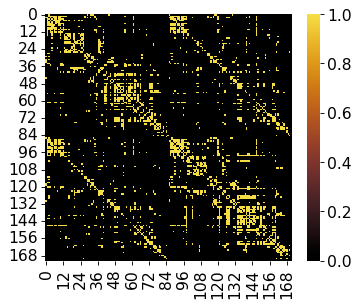

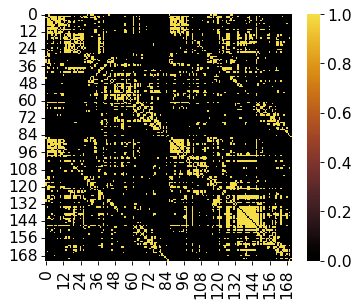

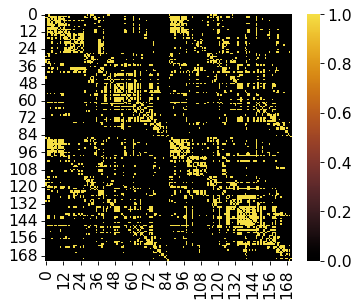

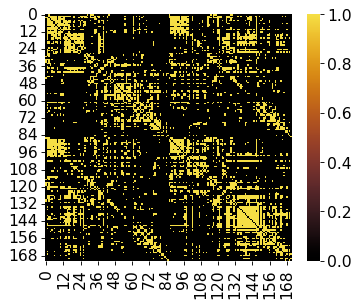

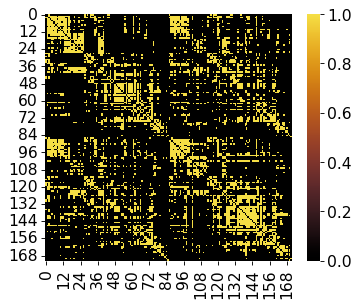

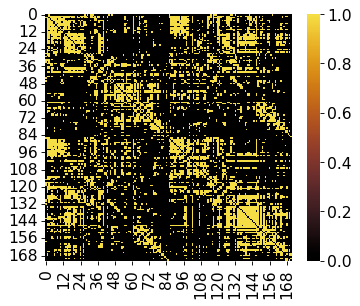

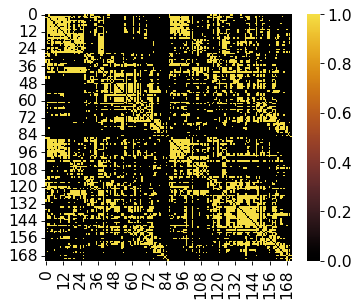

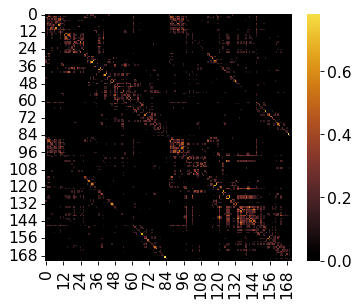

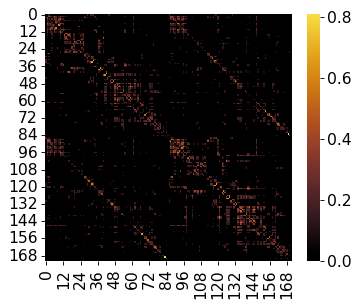

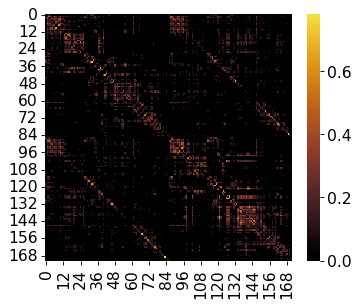

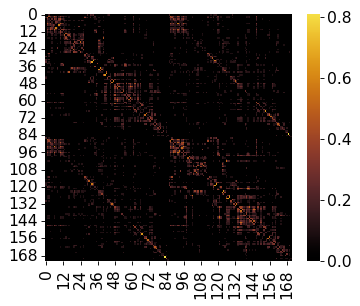

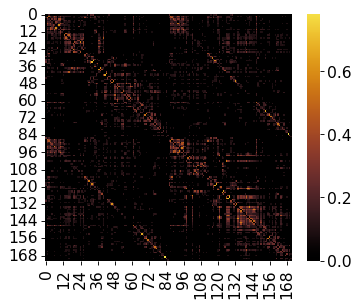

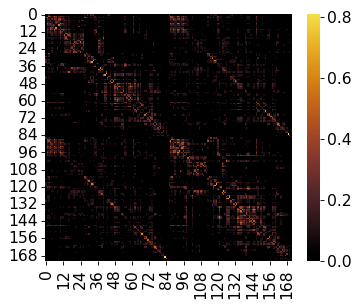

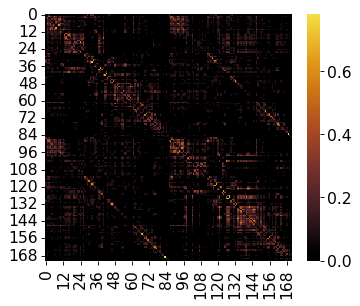

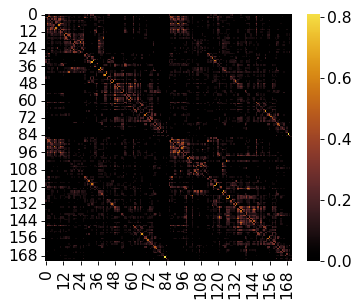

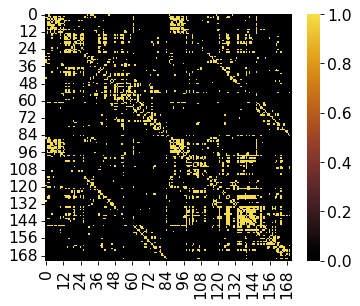

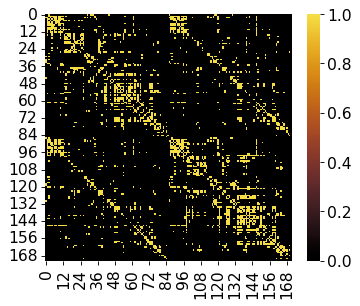

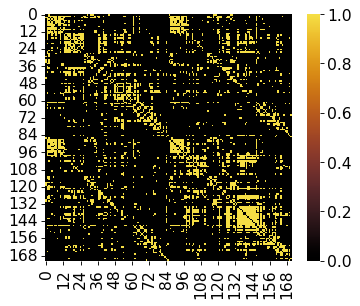

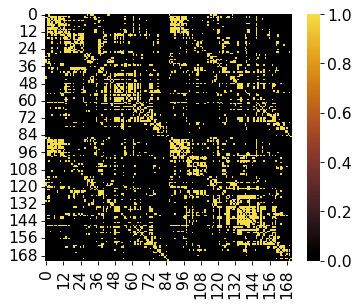

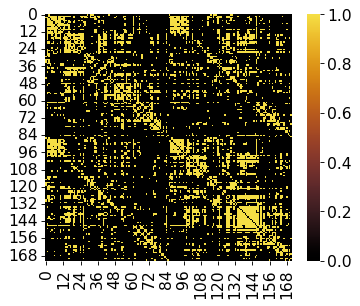

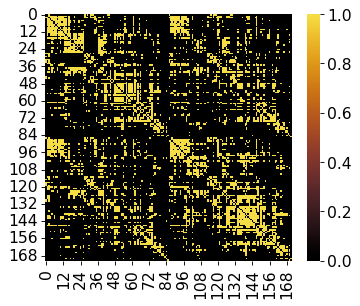

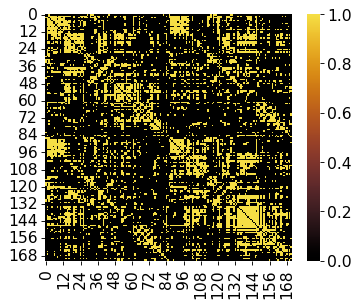

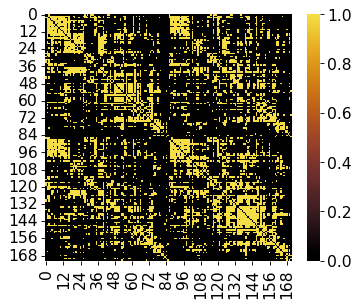

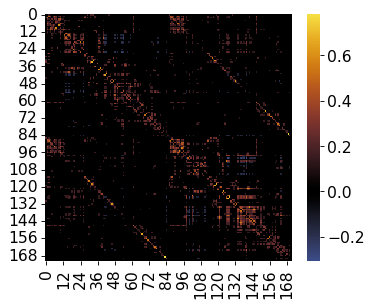

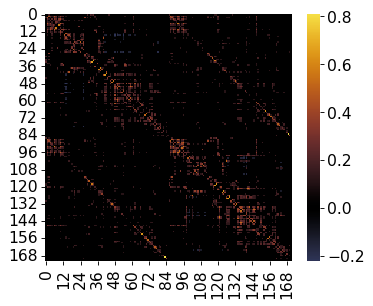

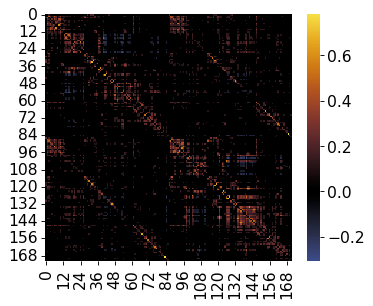

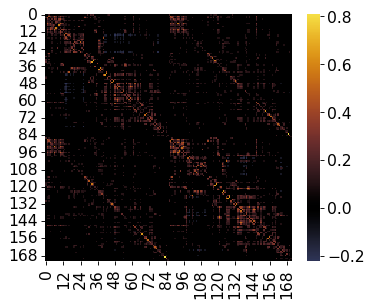

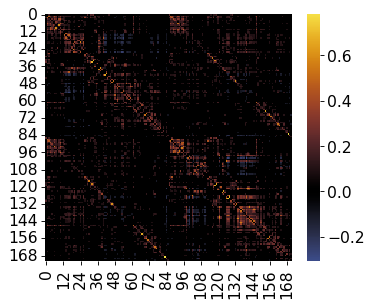

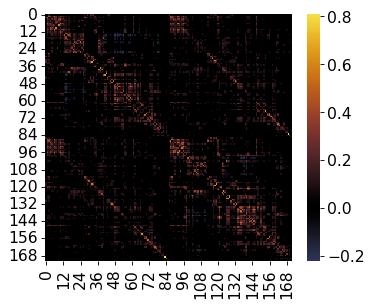

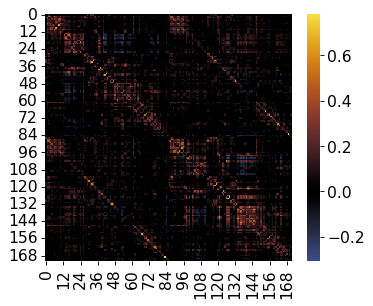

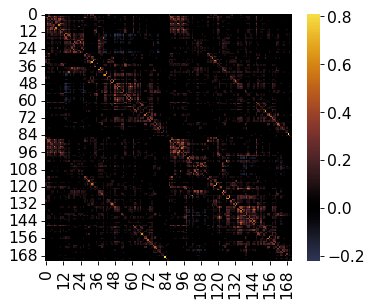

In [10]:
for (
    GRAPH_METHOD, 
    THRESHOLD, 
    EDGE_DEF, 
    EDGE_DENSITY,
    DATA_UNIT
) in ITERS:
    args.GRAPH_DEF = f'constructed'
    args.GRAPH_METHOD = GRAPH_METHOD
    args.THRESHOLDING = THRESHOLD
    args.EDGE_DEF = EDGE_DEF
    args.EDGE_DENSITY = EDGE_DENSITY
    args.LAYER_DEF = f'individual'
    args.DATA_UNIT = DATA_UNIT

    print(
        args.GRAPH_DEF,
        args.GRAPH_METHOD,
        args.THRESHOLDING,
        args.EDGE_DEF,
        args.EDGE_DENSITY,
        args.LAYER_DEF,
        args.DATA_UNIT,
    )

    BASE_path = f'{os.environ["HOME"]}/mouse_dataset/roi_results_v2'
    ROI_path = f'{BASE_path}/{PARC_DESC}'
    TS_path = f'{ROI_path}/runwise_timeseries'
    ROI_RESULTS_path = (
        f'{ROI_path}'
        f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
        f'/threshold-{args.THRESHOLDING}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
        f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
    )
    GRAPH_path = f'{ROI_RESULTS_path}/graphs'
    os.system(f'mkdir -p {GRAPH_path}')

    dataset_df = create_dataframe(files=glob.glob(f'{TS_path}/*', recursive=True))
    # display(dataset_df.head())

    cols = get_cols(args)
    graphs_df = create_graphs_df(args, dataset_df, cols)
    display(graphs_df.head())

    row = graphs_df.iloc[0]
    g = row['graph']
    fig = display_graph(args, g)

In [11]:
# ncols = 10 
# nrows=3
# fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), dpi=90, sharex=True, sharey=True)
# fig.tight_layout(h_pad=3, w_pad=3)

# for idx, row in graphs_df.iterrows():
#     sub, ses = row[['sub', 'ses']]
#     sub = int(sub[-2:])
#     ses = int(ses)
    
#     ax = axs[ses-1, sub-1]
#     g = row['graph']
#     sns.heatmap(gt.adjacency(g).todense(), ax=ax, square=True, cmap=cmr.iceburn, center=0)
#     ax.set(ylabel=f'ses {ses}', xlabel=f'animal {sub}')